<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/TutorialCallEvoJAXAlgorithmDirectly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to call EvoJAX algorithm directly

In this notebook, we show how to call directly EvoJAX Algorithm, using CMA-ES as an example.

In [1]:
! nvidia-smi

Mon Feb 20 04:30:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  ! pip install --upgrade pip
  ! pip install --upgrade flax==0.6.1
  ! pip install --upgrade evojax
else: 
  ! pip install --upgrade pip
  ! pip install --upgrade evojax
  ! pip install seaborn

from IPython.display import clear_output
clear_output()

In [3]:
import jax
from jax import numpy as jnp

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [57]:
PARAM_SIZE = 2

# define evaluation at a single point

def f(x: jnp.ndarray) -> jnp.ndarray:
  c = jnp.array([+0.3, -0.7])
  
  # # simple convex funciton
  # y = - jnp.sum(jnp.abs(x - c))
  # # make it harder:
  d = jnp.sum(jnp.abs(x - c))
  y = jnp.cos(d) * jnp.exp(-0.1*d)
  # so y is maximized when x = c
  return y

# ... test it
_x = jax.random.normal(
    key=jax.random.PRNGKey(123), 
    shape=(PARAM_SIZE,)
)
print(f'f({_x}) = {f(_x)}')

# evalute f in batch
f_batch = jax.vmap(f, in_axes=(0,), out_axes=0)

# ... test it
TEST_BATCH_SIZE = 3
_x_batch = jax.random.normal(
    key=jax.random.PRNGKey(123), 
    shape=(TEST_BATCH_SIZE, PARAM_SIZE,)
)
print(f'f_batch(\n{_x_batch}\n) = \n{f_batch(_x_batch)}')

f([-0.03049826  0.49289012]) = 0.040693823248147964
f_batch(
[[-0.29256076 -0.2805558 ]
 [-0.78786534 -0.90408975]
 [ 0.89289093  0.75706756]]
) = 
[ 0.4791347   0.2418831  -0.37558314]


In [58]:
from evojax.algo import PGPE, CMA_ES_JAX

In [59]:
n_population = 128
n_feature = PARAM_SIZE
n_iterations = 40
report_interval = 1

In [60]:
#@title CMA ES without particular initilization

solver = CMA_ES_JAX(
  pop_size=n_population,
  param_size=n_feature,
  init_stdev=0.1,
)

have_printed = False
recorded_best_fitness_no_init = []

for iter_ in range(1, 1 + n_iterations):
  solutions = solver.ask() 
  fitnesses = f_batch(solutions)
  solver.tell(fitnesses)

  if iter_ % report_interval == 0 or iter_ == 1 or iter_ == n_iterations:
    best_solutions = jnp.expand_dims(solver.best_params, axis=0)
    best_fitnesses = f_batch(best_solutions)
    recorded_best_fitness_no_init.append(
        np.array(best_fitnesses)[0]
    )

    if not have_printed:
      have_printed = True
      print(f'solutions.shape = {solutions.shape}')
      print(f'fitnesses.shape = {fitnesses.shape}')
      print(f'best_solutions.shape = {best_solutions.shape}')

    print(f'f_batch({best_solutions}) = {best_fitnesses}')

solutions.shape = (128, 2)
fitnesses.shape = (128,)
best_solutions.shape = (1, 2)
f_batch([[ 0.08474442 -0.073248  ]]) = [0.6121875]
f_batch([[ 0.17500642 -0.15183967]]) = [0.7309605]
f_batch([[ 0.3509241  -0.40125412]]) = [0.9072026]
f_batch([[ 0.39421523 -0.58534455]]) = [0.95804447]
f_batch([[ 0.32162884 -0.6903529 ]]) = [0.9963898]
f_batch([[ 0.3269463 -0.7115207]]) = [0.9954238]
f_batch([[ 0.3014449 -0.7109104]]) = [0.998689]
f_batch([[ 0.29477358 -0.69933814]]) = [0.99939406]
f_batch([[ 0.2975316 -0.6987489]]) = [0.9996212]
f_batch([[ 0.29991594 -0.6995431 ]]) = [0.9999458]
f_batch([[ 0.29953265 -0.7003363 ]]) = [0.99991935]
f_batch([[ 0.2997769 -0.7002779]]) = [0.99994975]
f_batch([[ 0.2999973 -0.6999719]]) = [0.9999969]
f_batch([[ 0.30000764 -0.6999761 ]]) = [0.9999969]
f_batch([[ 0.30001923 -0.69999397]]) = [0.9999975]
f_batch([[ 0.29999873 -0.70000386]]) = [0.99999946]
f_batch([[ 0.30000415 -0.70000184]]) = [0.99999934]
f_batch([[ 0.30000073 -0.70000076]]) = [0.9999999]
f_bat

In [61]:
#@title CMA ES with initilization
n_population = 128
n_feature = PARAM_SIZE
n_iterations = 40
report_interval = 1

solver = CMA_ES_JAX(
  pop_size=n_population,
  param_size=n_feature,
  mean=jnp.array([0.35, -0.65]),
  init_stdev=0.1,
)

have_printed = False
recorded_best_fitness_with_init = []

for iter_ in range(1, 1 + n_iterations):
  solutions = solver.ask() 
  fitnesses = f_batch(solutions)
  solver.tell(fitnesses)

  if iter_ % report_interval == 0 or iter_ == 1 or iter_ == n_iterations:
    best_solutions = jnp.expand_dims(solver.best_params, axis=0)
    best_fitnesses = f_batch(best_solutions)
    recorded_best_fitness_with_init.append(
        np.array(best_fitnesses)[0]
    )

    if not have_printed:
      have_printed = True
      print(f'solutions.shape = {solutions.shape}')
      print(f'fitnesses.shape = {fitnesses.shape}')
      print(f'best_solutions.shape = {best_solutions.shape}')

    print(f'f_batch({best_solutions}) = {best_fitnesses}')


solutions.shape = (128, 2)
fitnesses.shape = (128,)
best_solutions.shape = (1, 2)
f_batch([[ 0.30595613 -0.6888452 ]]) = [0.99814427]
f_batch([[ 0.29828358 -0.6956377 ]]) = [0.99937385]
f_batch([[ 0.2994544 -0.7001903]]) = [0.9999261]
f_batch([[ 0.29997295 -0.70111954]]) = [0.9998847]
f_batch([[ 0.29916427 -0.7002495 ]]) = [0.99989086]
f_batch([[ 0.3000644 -0.7009134]]) = [0.9999017]
f_batch([[ 0.3001192  -0.70024765]]) = [0.9999633]
f_batch([[ 0.29999012 -0.7001805 ]]) = [0.9999809]
f_batch([[ 0.3000445  -0.70005876]]) = [0.9999897]
f_batch([[ 0.30002174 -0.7000235 ]]) = [0.99999547]
f_batch([[ 0.29999495 -0.7000103 ]]) = [0.99999845]
f_batch([[ 0.30000436 -0.70000714]]) = [0.99999887]
f_batch([[ 0.3000021  -0.69999635]]) = [0.99999946]
f_batch([[ 0.30000085 -0.6999991 ]]) = [0.99999976]
f_batch([[ 0.29999956 -0.6999996 ]]) = [0.9999999]
f_batch([[ 0.3       -0.6999999]]) = [1.]
f_batch([[ 0.29999992 -0.6999999 ]]) = [1.]
f_batch([[ 0.30000007 -0.6999999 ]]) = [1.]
f_batch([[ 0.299999

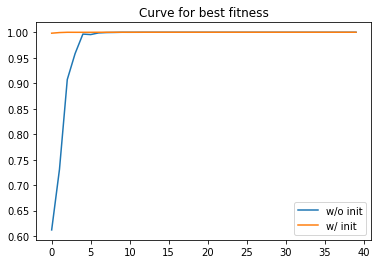

In [62]:
plt.plot(recorded_best_fitness_no_init, label='w/o init')
plt.plot(recorded_best_fitness_with_init, label='w/ init')
plt.legend()
plt.title('Curve for best fitness')
plt.show()